In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
def load_processed_data():
    panels = pd.read_csv('../data/processed/panels_processed.csv')
    pedestrian_zones = pd.read_csv('../data/processed/pedestrian_zones_processed.csv')
    vehicle_traffic = pd.read_csv('../data/processed/vehicle_traffic_clean.csv')
    return panels, pedestrian_zones, vehicle_traffic

def prepare_geospatial_data(df, lat_col='latitude', lon_col='longitude'):
    df_clean = df.dropna(subset=[lat_col, lon_col])
    df_clean = df_clean[(df_clean[lat_col] != 0) & (df_clean[lon_col] != 0)]
    
    # Paris bounds
    mask = (
        (df_clean[lat_col] >= 48.8) & (df_clean[lat_col] <= 48.9) &
        (df_clean[lon_col] >= 2.2) & (df_clean[lon_col] <= 2.5)
    )
    return df_clean[mask].copy()

panels, pedestrian_zones, vehicle_traffic = load_processed_data()
panels_clean = prepare_geospatial_data(panels)
pedestrian_clean = prepare_geospatial_data(pedestrian_zones)
vehicle_clean = prepare_geospatial_data(vehicle_traffic)

print(f"Cleaned datasets - Panels: {len(panels_clean)}, Pedestrian: {len(pedestrian_clean)}, Traffic: {len(vehicle_clean)}")

Cleaned datasets - Panels: 285, Pedestrian: 626, Traffic: 7604


In [3]:
# Panel distribution
panel_dist = panels_clean['arrondissement'].value_counts()
ped_dist = pedestrian_clean['arrondissement'].value_counts()

print("Top arrondissements by panels:", panel_dist.head().to_dict())
print("Top arrondissements by pedestrian zones:", ped_dist.head().to_dict())

if len(vehicle_clean) > 0:
    print(f"Total traffic events: {len(vehicle_clean):,}")
    print(f"Total count: {vehicle_clean['count'].sum():,}")
    print("Transport modes:", vehicle_clean['mode'].value_counts().to_dict())

Top arrondissements by panels: {75020.0: 35, 75019.0: 33, 75013.0: 26, 75011.0: 22, 75018.0: 20}
Top arrondissements by pedestrian zones: {20: 66, 13: 59, 19: 56, 18: 50, 12: 48}
Total traffic events: 7,604
Total count: 423,154
Transport modes: {'2 roues motorisées': 1385, 'Trottinettes + vélos': 1367, 'Véhicules légers < 3,5t': 1313, 'Vélos': 982, 'Trottinettes': 937, 'Véhicules lourds > 3,5t': 746, 'Autobus et autocars': 702, 'van': 172}


In [4]:
def calculate_proximity_metrics(df1, df2, max_distance_km=0.5):
    proximities = []
    
    for idx1, row1 in df1.iterrows():
        distances = []
        for idx2, row2 in df2.iterrows():
            dist = geodesic(
                (row1['latitude'], row1['longitude']),
                (row2['latitude'], row2['longitude'])
            ).kilometers
            distances.append(dist)
        
        min_distance = min(distances) if distances else float('inf')
        nearby_count = sum(1 for d in distances if d <= max_distance_km)
        
        proximities.append({
            'index': idx1,
            'min_distance_km': min_distance,
            'nearby_count': nearby_count,
            'proximity_score': nearby_count / max(min_distance, 0.1)
        })
    
    return pd.DataFrame(proximities)

# Calculate proximities
panel_to_pedestrian = calculate_proximity_metrics(panels_clean, pedestrian_clean)
panels_with_proximity = panels_clean.reset_index(drop=True).join(panel_to_pedestrian.set_index('index'))

In [5]:
from sklearn.neighbors import BallTree
import numpy as np

def assign_arrondissement_to_traffic_fast(vehicle_clean, panels_clean, pedestrian_clean):
    """
    Fast arrondissement assignment using BallTree spatial index
    """
    print("🗺️ Fast mapping vehicle traffic to arrondissements...")
    
    # Create reference dataset
    reference_points = []
    
    for _, row in panels_clean.iterrows():
        if pd.notna(row['arrondissement']) and row['arrondissement'] != '':
            reference_points.append({
                'latitude': row['latitude'],
                'longitude': row['longitude'],
                'arrondissement': row['arrondissement']
            })
    
    for _, row in pedestrian_clean.iterrows():
        if pd.notna(row['arrondissement']) and row['arrondissement'] != '':
            reference_points.append({
                'latitude': row['latitude'],
                'longitude': row['longitude'],
                'arrondissement': row['arrondissement']
            })
    
    reference_df = pd.DataFrame(reference_points)
    print(f"Created reference dataset with {len(reference_df)} known locations")
    
    # Convert to radians for BallTree (haversine metric)
    ref_coords = np.radians(reference_df[['latitude', 'longitude']].values)
    traffic_coords = np.radians(vehicle_clean[['latitude', 'longitude']].values)
    
    # Build spatial index
    tree = BallTree(ref_coords, metric='haversine')
    
    # Find nearest reference point for each traffic point
    distances, indices = tree.query(traffic_coords, k=1)
    
    # Convert distances back to km (from radians)
    distances_km = distances.flatten() * 6371  # Earth radius in km
    
    # Assign arrondissements
    vehicle_with_arr = vehicle_clean.copy()
    vehicle_with_arr['arrondissement'] = reference_df.iloc[indices.flatten()]['arrondissement'].values
    vehicle_with_arr['distance_to_reference'] = distances_km
    
    # Show results
    arr_counts = vehicle_with_arr['arrondissement'].value_counts()
    print(f"\n📊 Traffic events mapped to {len(arr_counts)} arrondissements")
    print(f"📏 Average distance to reference: {distances_km.mean():.3f} km")
    
    return vehicle_with_arr

# Use the fast version
vehicle_clean = assign_arrondissement_to_traffic_fast(vehicle_clean, panels_clean, pedestrian_clean)

🗺️ Fast mapping vehicle traffic to arrondissements...
Created reference dataset with 911 known locations

📊 Traffic events mapped to 20 arrondissements
📏 Average distance to reference: 0.081 km


In [6]:
panels_with_traffic = panels_with_proximity.copy()  

if len(vehicle_clean) > 0:
    # Aggregate traffic by location
    vehicle_aggregated = vehicle_clean.groupby(['latitude', 'longitude']).agg({
        'count': 'sum',
        'site_id': 'first',
        'mode': lambda x: x.mode().iloc[0] if not x.empty else 'unknown'
    }).reset_index()
    
    # High-traffic locations (top 25%)
    high_traffic_threshold = vehicle_aggregated['count'].quantile(0.75)
    high_traffic_locations = vehicle_aggregated[vehicle_aggregated['count'] >= high_traffic_threshold]
    
    # Panels proximity to traffic
    panel_to_traffic = calculate_proximity_metrics(panels_clean, high_traffic_locations)
    panels_with_traffic = panels_with_proximity.join(panel_to_traffic.set_index('index'), rsuffix='_traffic')
    
    print(f"High-traffic locations: {len(high_traffic_locations)}")
else:
    high_traffic_locations = pd.DataFrame()
    print("No traffic data for proximity analysis")

High-traffic locations: 10


In [7]:
def analyze_arrondissement_patterns():
    panel_density = panels_clean['arrondissement'].value_counts().reset_index()
    panel_density.columns = ['arrondissement', 'panel_count']
    
    ped_density = pedestrian_clean['arrondissement'].value_counts().reset_index()
    ped_density.columns = ['arrondissement', 'pedestrian_zones']
    
    arr_analysis = panel_density.merge(ped_density, on='arrondissement', how='outer')
    
    # Now we can use traffic data with arrondissements
    if len(vehicle_clean) > 0 and 'arrondissement' in vehicle_clean.columns:
        traffic_by_arr = vehicle_clean.groupby('arrondissement')['count'].sum().reset_index()
        traffic_by_arr.columns = ['arrondissement', 'total_traffic']
        arr_analysis = arr_analysis.merge(traffic_by_arr, on='arrondissement', how='outer')
        
        # Also add traffic event count
        traffic_events_by_arr = vehicle_clean['arrondissement'].value_counts().reset_index()
        traffic_events_by_arr.columns = ['arrondissement', 'traffic_events']
        arr_analysis = arr_analysis.merge(traffic_events_by_arr, on='arrondissement', how='outer')
        
        print("✅ Successfully integrated traffic data by arrondissement")
    else:
        arr_analysis['total_traffic'] = 0
        arr_analysis['traffic_events'] = 0
    
    arr_analysis = arr_analysis.fillna(0)
    
    # Enhanced commercial potential score with traffic data
    max_traffic = arr_analysis['total_traffic'].max() if arr_analysis['total_traffic'].max() > 0 else 1
    arr_analysis['traffic_score'] = (arr_analysis['total_traffic'] / max_traffic) * 100
    
    # Add traffic density score
    max_events = arr_analysis['traffic_events'].max() if arr_analysis['traffic_events'].max() > 0 else 1
    arr_analysis['traffic_density'] = (arr_analysis['traffic_events'] / max_events) * 100
    
    # Updated commercial potential with both traffic metrics
    arr_analysis['commercial_potential'] = (
        arr_analysis['panel_count'] * 0.25 +
        arr_analysis['pedestrian_zones'] * 0.35 +
        arr_analysis['traffic_score'] * 0.25 +
        arr_analysis['traffic_density'] * 0.15
    )
    
    return arr_analysis.sort_values('commercial_potential', ascending=False)

arr_analysis = analyze_arrondissement_patterns()
print("🏆 TOP 10 ARRONDISSEMENTS WITH INTEGRATED TRAFFIC DATA:")
print(arr_analysis.head(10)[['arrondissement', 'panel_count', 'pedestrian_zones', 'total_traffic', 'traffic_events', 'commercial_potential']].to_string(index=False))

✅ Successfully integrated traffic data by arrondissement
🏆 TOP 10 ARRONDISSEMENTS WITH INTEGRATED TRAFFIC DATA:
 arrondissement  panel_count  pedestrian_zones  total_traffic  traffic_events  commercial_potential
            4.0          0.0              33.0        75300.0          1731.0             46.632999
            2.0          0.0              14.0        93736.0          1433.0             42.317678
            1.0          0.0              26.0        66293.0           992.0             35.376961
           10.0          0.0              26.0        40360.0           801.0             26.805349
            9.0          0.0              24.0        43121.0           741.0             26.321795
        75004.0          6.0               0.0        50046.0          1027.0             23.747073
           20.0          0.0              66.0            0.0             0.0             23.100000
           13.0          0.0              59.0          939.0            39.0           

In [8]:
def identify_commercial_clusters():
    all_locations = []
    
    # Add panels
    for _, row in panels_clean.iterrows():
        all_locations.append({
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'type': 'civic_panel',
            'weight': 1.0,
            'format_score': row.get('format_1m2', 0) + row.get('format_2m2', 0),
            'arrondissement': row.get('arrondissement', '')
        })
    
    # Add pedestrian zones
    for _, row in pedestrian_clean.iterrows():
        all_locations.append({
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'type': 'pedestrian_zone',
            'weight': 2.0,
            'format_score': 0,
            'arrondissement': row.get('arrondissement', '')
        })
    
    # Add high-traffic locations if available
    if 'high_traffic_locations' in locals() and len(high_traffic_locations) > 0:
        for _, row in high_traffic_locations.iterrows():
            all_locations.append({
                'latitude': row['latitude'],
                'longitude': row['longitude'],
                'type': 'high_traffic',
                'weight': 1.5,
                'format_score': row['count'] / 100,
                'arrondissement': ''
            })
    
    locations_df = pd.DataFrame(all_locations)
    
    # Clustering
    features = ['latitude', 'longitude', 'weight', 'format_score']
    X = locations_df[features].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    dbscan = DBSCAN(eps=0.3, min_samples=3)
    clusters = dbscan.fit_predict(X_scaled)
    
    locations_df['cluster'] = clusters
    
    # Cluster analysis
    cluster_analysis = locations_df[locations_df['cluster'] != -1].groupby('cluster').agg({
        'latitude': 'mean',
        'longitude': 'mean',
        'weight': 'sum',
        'format_score': 'sum',
        'type': 'count'
    }).reset_index()
    
    cluster_analysis.columns = ['cluster', 'center_lat', 'center_lon', 'total_weight', 'total_score', 'location_count']
    cluster_analysis['commercial_score'] = cluster_analysis['total_weight'] * cluster_analysis['total_score']
    
    return locations_df, cluster_analysis.sort_values('commercial_score', ascending=False)

locations_df, cluster_analysis = identify_commercial_clusters()
print(f"Found {len(cluster_analysis)} commercial clusters")

Found 11 commercial clusters


In [9]:
def create_correlation_analysis():
    correlations = []
    
    # Traffic proximity correlations
    if 'nearby_count_traffic' in panels_with_traffic.columns:
        corr_ped_traffic, p_val = pearsonr(
            panels_with_traffic['nearby_count'].fillna(0),
            panels_with_traffic['nearby_count_traffic'].fillna(0)
        )
        
        correlations.append({
            'metric_1': 'Proximity to Pedestrian Zones',
            'metric_2': 'Proximity to High Traffic',
            'correlation': corr_ped_traffic,
            'p_value': p_val,
            'significance': 'Significant' if p_val < 0.05 else 'Not Significant'
        })
    
    # Arrondissement-level correlations with traffic data
    if len(arr_analysis) > 1:
        # Panel count vs pedestrian zones
        corr_panel_ped, p_val2 = pearsonr(
            arr_analysis['panel_count'],
            arr_analysis['pedestrian_zones']
        )
        
        correlations.append({
            'metric_1': 'Panel Count by Arrondissement',
            'metric_2': 'Pedestrian Zones by Arrondissement',
            'correlation': corr_panel_ped,
            'p_value': p_val2,
            'significance': 'Significant' if p_val2 < 0.05 else 'Not Significant'
        })
        
        # Panel count vs traffic volume
        if arr_analysis['total_traffic'].sum() > 0:
            corr_panel_traffic, p_val3 = pearsonr(
                arr_analysis['panel_count'],
                arr_analysis['total_traffic']
            )
            
            correlations.append({
                'metric_1': 'Panel Count by Arrondissement',
                'metric_2': 'Traffic Volume by Arrondissement',
                'correlation': corr_panel_traffic,
                'p_value': p_val3,
                'significance': 'Significant' if p_val3 < 0.05 else 'Not Significant'
            })
            
            # Pedestrian zones vs traffic volume
            corr_ped_traffic_arr, p_val4 = pearsonr(
                arr_analysis['pedestrian_zones'],
                arr_analysis['total_traffic']
            )
            
            correlations.append({
                'metric_1': 'Pedestrian Zones by Arrondissement',
                'metric_2': 'Traffic Volume by Arrondissement',
                'correlation': corr_ped_traffic_arr,
                'p_value': p_val4,
                'significance': 'Significant' if p_val4 < 0.05 else 'Not Significant'
            })
            
            # Traffic events vs traffic volume
            corr_events_volume, p_val5 = pearsonr(
                arr_analysis['traffic_events'],
                arr_analysis['total_traffic']
            )
            
            correlations.append({
                'metric_1': 'Traffic Events by Arrondissement',
                'metric_2': 'Traffic Volume by Arrondissement',
                'correlation': corr_events_volume,
                'p_value': p_val5,
                'significance': 'Significant' if p_val5 < 0.05 else 'Not Significant'
            })
    
    return pd.DataFrame(correlations)

correlation_results = create_correlation_analysis()
print("🔗 ENHANCED CORRELATION RESULTS WITH TRAFFIC DATA:")
if len(correlation_results) > 0:
    print(correlation_results.to_string(index=False))
else:
    print("No correlations calculated")

🔗 ENHANCED CORRELATION RESULTS WITH TRAFFIC DATA:
                          metric_1                           metric_2  correlation      p_value    significance
     Proximity to Pedestrian Zones          Proximity to High Traffic     0.262832 6.894331e-06     Significant
     Panel Count by Arrondissement Pedestrian Zones by Arrondissement    -0.587637 6.699024e-05     Significant
     Panel Count by Arrondissement   Traffic Volume by Arrondissement    -0.272980 8.833080e-02 Not Significant
Pedestrian Zones by Arrondissement   Traffic Volume by Arrondissement     0.125913 4.388252e-01 Not Significant
  Traffic Events by Arrondissement   Traffic Volume by Arrondissement     0.979103 6.800719e-28     Significant


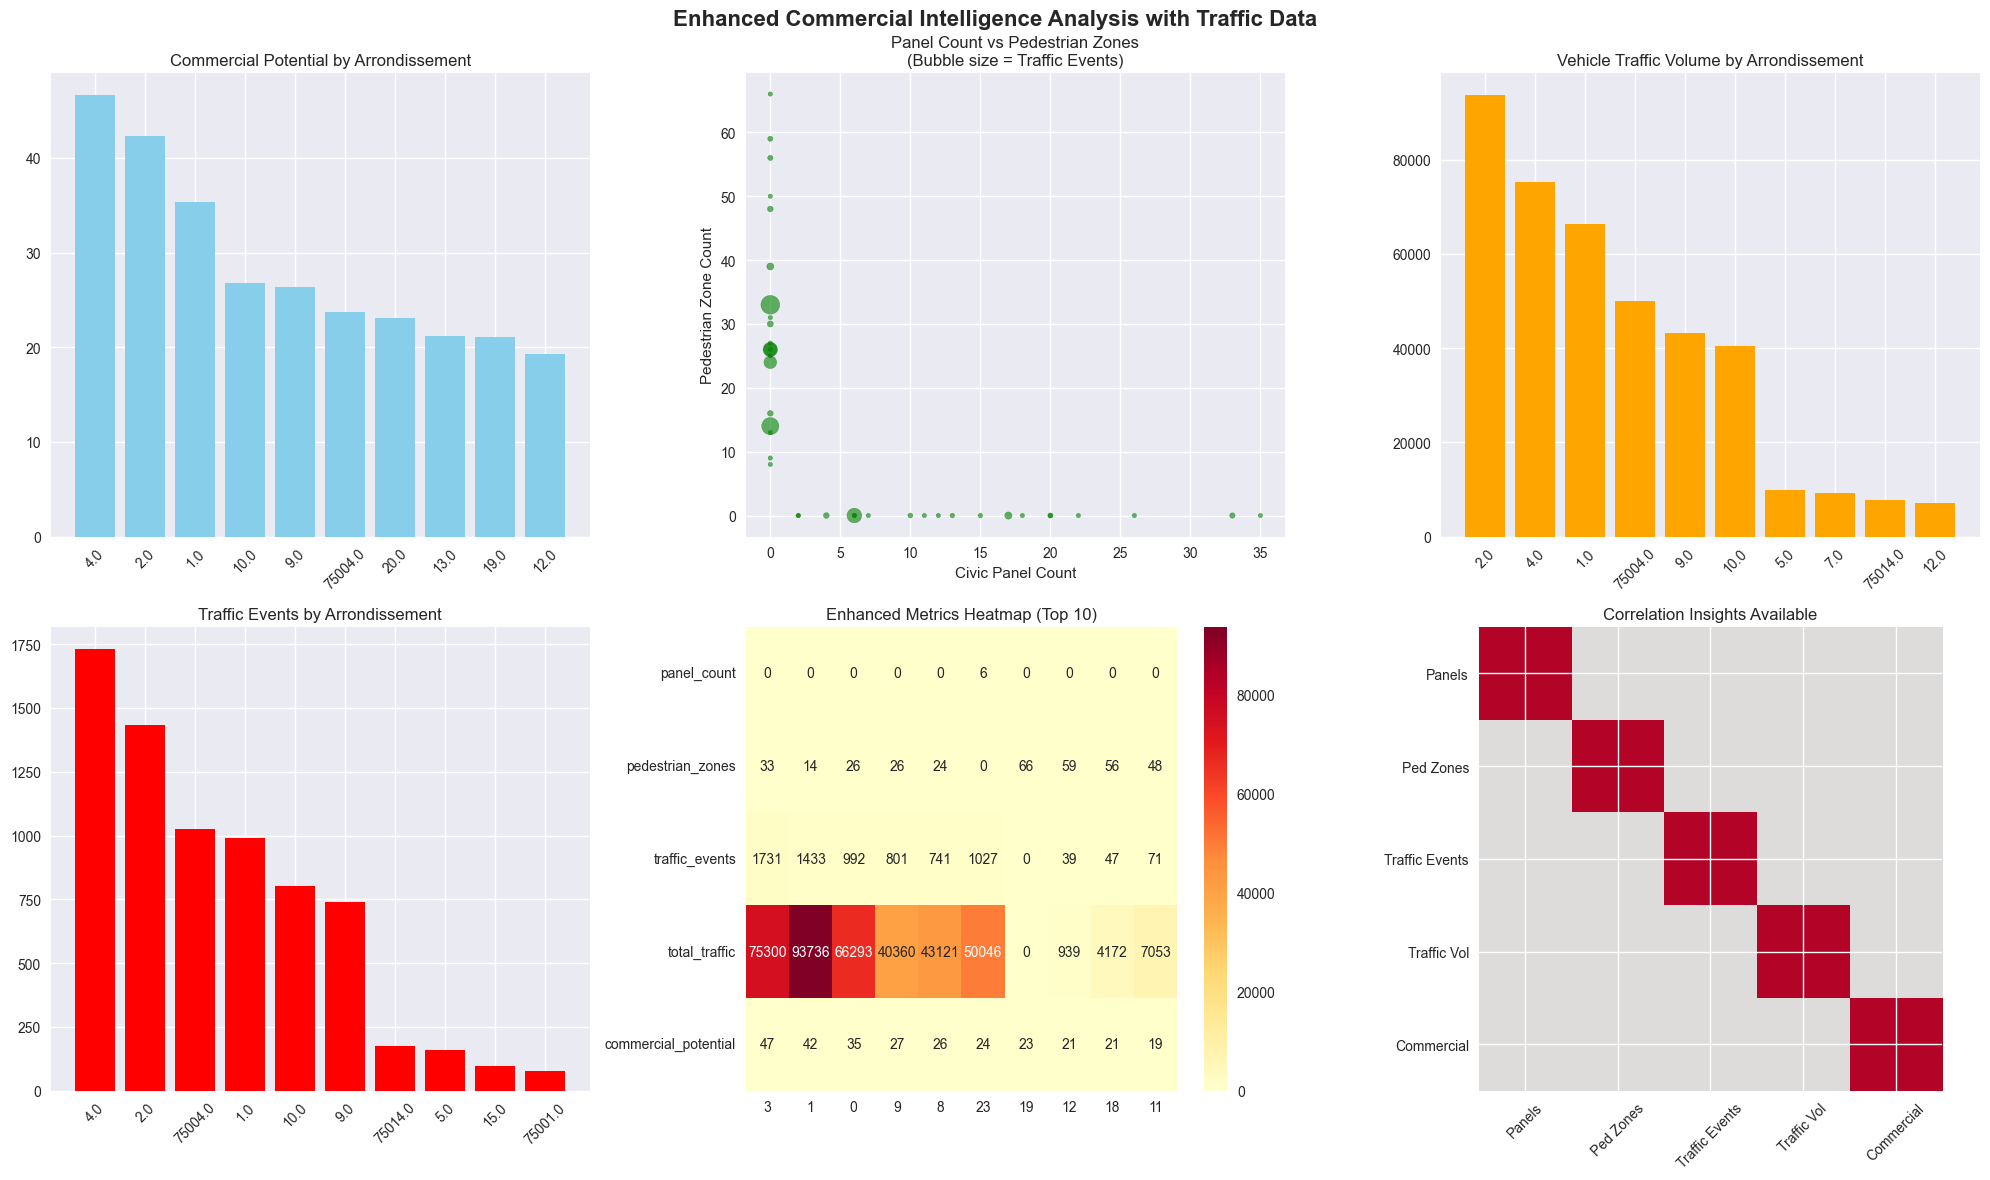

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Enhanced Commercial Intelligence Analysis with Traffic Data', fontsize=16, fontweight='bold')

# Commercial potential by arrondissement
arr_top10 = arr_analysis.head(10)
axes[0,0].bar(range(len(arr_top10)), arr_top10['commercial_potential'], color='skyblue')
axes[0,0].set_title('Commercial Potential by Arrondissement')
axes[0,0].set_xticks(range(len(arr_top10)))
axes[0,0].set_xticklabels(arr_top10['arrondissement'], rotation=45)

# Panel vs Pedestrian scatter with traffic bubble size
axes[0,1].scatter(arr_analysis['panel_count'], arr_analysis['pedestrian_zones'], 
                  s=arr_analysis['traffic_events']/10+10, alpha=0.6, c='green')
axes[0,1].set_title('Panel Count vs Pedestrian Zones\n(Bubble size = Traffic Events)')
axes[0,1].set_xlabel('Civic Panel Count')
axes[0,1].set_ylabel('Pedestrian Zone Count')

# Traffic volume by arrondissement
if arr_analysis['total_traffic'].sum() > 0:
    top_traffic = arr_analysis.nlargest(10, 'total_traffic')
    axes[0,2].bar(range(len(top_traffic)), top_traffic['total_traffic'], color='orange')
    axes[0,2].set_title('Vehicle Traffic Volume by Arrondissement')
    axes[0,2].set_xticks(range(len(top_traffic)))
    axes[0,2].set_xticklabels(top_traffic['arrondissement'], rotation=45)
else:
    axes[0,2].text(0.5, 0.5, 'No Traffic Data', ha='center', va='center', transform=axes[0,2].transAxes)

# Traffic events by arrondissement
if arr_analysis['traffic_events'].sum() > 0:
    top_events = arr_analysis.nlargest(10, 'traffic_events')
    axes[1,0].bar(range(len(top_events)), top_events['traffic_events'], color='red')
    axes[1,0].set_title('Traffic Events by Arrondissement')
    axes[1,0].set_xticks(range(len(top_events)))
    axes[1,0].set_xticklabels(top_events['arrondissement'], rotation=45)

# Enhanced heatmap with traffic data
metrics_cols = ['panel_count', 'pedestrian_zones', 'traffic_events', 'total_traffic', 'commercial_potential']
available_cols = [col for col in metrics_cols if col in arr_analysis.columns]
metrics_heatmap = arr_analysis[available_cols].head(10)
sns.heatmap(metrics_heatmap.T, annot=True, cmap='YlOrRd', ax=axes[1,1], fmt='.0f')
axes[1,1].set_title('Enhanced Metrics Heatmap (Top 10)')

# Correlation matrix
if len(correlation_results) > 0:
    # Create correlation matrix for visualization
    corr_matrix = np.eye(len(available_cols))
    corr_labels = ['Panels', 'Ped Zones', 'Traffic Events', 'Traffic Vol', 'Commercial'][:len(available_cols)]
    
    im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1,2].set_title('Correlation Insights Available')
    axes[1,2].set_xticks(range(len(corr_labels)))
    axes[1,2].set_yticks(range(len(corr_labels)))
    axes[1,2].set_xticklabels(corr_labels, rotation=45)
    axes[1,2].set_yticklabels(corr_labels)

plt.tight_layout()
plt.show()

In [11]:
def create_commercial_map(locations_df, cluster_analysis):
    m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
    
    type_colors = {'civic_panel': 'blue', 'pedestrian_zone': 'green', 'high_traffic': 'red'}
    
    for _, row in locations_df.iterrows():
        if row['cluster'] != -1:
            folium.CircleMarker(
                [row['latitude'], row['longitude']],
                radius=5,
                popup=f"Type: {row['type']}<br>Cluster: {row['cluster']}",
                color=type_colors.get(row['type'], 'gray'),
                fill=True,
                fillOpacity=0.7
            ).add_to(m)
    
    # Top clusters as commercial opportunities
    for _, cluster in cluster_analysis.head(10).iterrows():
        folium.Marker(
            [cluster['center_lat'], cluster['center_lon']],
            popup=f"Commercial Score: {cluster['commercial_score']:.2f}",
            icon=folium.Icon(color='red', icon='star')
        ).add_to(m)
    
    return m

commercial_map = create_commercial_map(locations_df, cluster_analysis)
commercial_map.save('commercial_intelligence_map.html')
commercial_map

In [12]:
def generate_recommendations(cluster_analysis, arr_analysis):
    recommendations = []
    
    top_clusters = cluster_analysis.head(5)
    for i, cluster in top_clusters.iterrows():
        score = cluster['commercial_score']
        priority = "HIGH" if score > 10 else "MEDIUM" if score > 5 else "LOW"
        
        recommendations.append({
            'cluster_id': cluster['cluster'],
            'latitude': cluster['center_lat'],
            'longitude': cluster['center_lon'],
            'priority': priority,
            'commercial_score': score,
            'location_count': cluster['location_count'],
            'recommendation': f"Deploy {2 if priority == 'HIGH' else 1} advertising panel(s)"
        })
    
    return pd.DataFrame(recommendations)

recommendations = generate_recommendations(cluster_analysis, arr_analysis)
print("Commercial Recommendations:")
print(recommendations[['cluster_id', 'priority', 'commercial_score', 'recommendation']].to_string(index=False))

Commercial Recommendations:
 cluster_id priority  commercial_score                recommendation
        0.0     HIGH           57600.0 Deploy 2 advertising panel(s)
        2.0     HIGH              81.0 Deploy 2 advertising panel(s)
        1.0     HIGH              49.0 Deploy 2 advertising panel(s)
        4.0     HIGH              49.0 Deploy 2 advertising panel(s)
        6.0     HIGH              25.0 Deploy 2 advertising panel(s)


In [13]:
def create_comprehensive_commercial_map():
    """
    Create the ultimate commercial intelligence map combining all datasets
    """
    print("🗺️ Creating comprehensive commercial intelligence map...")
    
    # Create base map centered on Paris
    m = folium.Map(
        location=[48.8566, 2.3522],
        zoom_start=11,
        tiles='CartoDB positron'
    )
    
    # Define color schemes
    colors = {
        'civic_panel': '#1f77b4',      # Blue
        'pedestrian_zone': '#2ca02c',   # Green  
        'high_traffic': '#ff7f0e',      # Orange
        'commercial_cluster': '#d62728', # Red
        'opportunity': '#9467bd'        # Purple
    }
    
    # 1. ADD TRAFFIC HEATMAP LAYER
    if len(vehicle_clean) > 0:
        traffic_heatmap_data = []
        for _, row in vehicle_clean.iterrows():
            # Weight by traffic count
            weight = min(row['count'] / 100, 10)  # Cap at 10 for visualization
            traffic_heatmap_data.append([row['latitude'], row['longitude'], weight])
        
        traffic_heatmap = HeatMap(
            traffic_heatmap_data,
            name='Traffic Intensity',
            radius=15,
            blur=10,
            gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}
        )
        traffic_heatmap.add_to(m)
    
    # 2. ADD CIVIC PANELS
    panel_cluster = MarkerCluster(name="Civic Panels", overlay=True, control=True)
    for _, row in panels_clean.iterrows():
        # Get commercial potential for this arrondissement
        arr_score = arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]['commercial_potential'].iloc[0] if len(arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]) > 0 else 0
        
        popup_text = f"""
        <b>🏛️ Civic Panel</b><br>
        📍 Arrondissement: {row['arrondissement']}<br>
        📏 Format 1m²: {row.get('format_1m2', 0)}<br>
        📏 Format 2m²: {row.get('format_2m2', 0)}<br>
        🎯 Commercial Score: {arr_score:.1f}
        """
        
        folium.CircleMarker(
            [row['latitude'], row['longitude']],
            radius=6,
            popup=folium.Popup(popup_text, max_width=200),
            color=colors['civic_panel'],
            fill=True,
            fillOpacity=0.7,
            weight=2
        ).add_to(panel_cluster)
    
    panel_cluster.add_to(m)
    
    # 3. ADD PEDESTRIAN ZONES
    ped_cluster = MarkerCluster(name="Pedestrian Zones", overlay=True, control=True)
    for _, row in pedestrian_clean.iterrows():
        arr_score = arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]['commercial_potential'].iloc[0] if len(arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]) > 0 else 0
        
        popup_text = f"""
        <b>🚶 Pedestrian Zone</b><br>
        📍 {row.get('zone_name', 'Unnamed Zone')}<br>
        🏢 Arrondissement: {row['arrondissement']}<br>
        🎯 Commercial Score: {arr_score:.1f}
        """
        
        folium.CircleMarker(
            [row['latitude'], row['longitude']],
            radius=8,
            popup=folium.Popup(popup_text, max_width=200),
            color=colors['pedestrian_zone'],
            fill=True,
            fillOpacity=0.8,
            weight=2
        ).add_to(ped_cluster)
    
    ped_cluster.add_to(m)
    
    # 4. ADD HIGH-TRAFFIC LOCATIONS
    if len(high_traffic_locations) > 0:
        traffic_cluster = MarkerCluster(name="High-Traffic Locations", overlay=True, control=True)
        for _, row in high_traffic_locations.iterrows():
            popup_text = f"""
            <b>🚗 High-Traffic Location</b><br>
            🔢 Traffic Count: {row['count']:,}<br>
            🚌 Primary Mode: {row['mode']}<br>
            📍 Site: {row.get('site_id', 'Unknown')}
            """
            
            folium.CircleMarker(
                [row['latitude'], row['longitude']],
                radius=max(4, min(row['count']/1000, 12)),  # Size based on traffic
                popup=folium.Popup(popup_text, max_width=200),
                color=colors['high_traffic'],
                fill=True,
                fillOpacity=0.6,
                weight=2
            ).add_to(traffic_cluster)
        
        traffic_cluster.add_to(m)
    
    # 5. ADD COMMERCIAL OPPORTUNITY CLUSTERS
    opportunity_group = folium.FeatureGroup(name="🎯 Commercial Opportunities", overlay=True, control=True)
    
    # Top commercial clusters
    for _, cluster in cluster_analysis.head(10).iterrows():
        popup_text = f"""
        <b>🎯 COMMERCIAL OPPORTUNITY</b><br>
        ⭐ Commercial Score: {cluster['commercial_score']:.1f}<br>
        📊 Activity Points: {cluster['location_count']}<br>
        🏋️ Total Weight: {cluster['total_weight']:.1f}<br>
        💡 Recommendation: Deploy 2-3 advertising panels
        """
        
        # Use star icon for top opportunities
        folium.Marker(
            [cluster['center_lat'], cluster['center_lon']],
            popup=folium.Popup(popup_text, max_width=250),
            icon=folium.Icon(
                color='red', 
                icon='star',
                prefix='fa'
            )
        ).add_to(opportunity_group)
        
        # Add circle around cluster area
        folium.Circle(
            [cluster['center_lat'], cluster['center_lon']],
            radius=200,  # 200m radius
            popup=f"Commercial Cluster {cluster['cluster']}",
            color=colors['commercial_cluster'],
            fill=True,
            fillOpacity=0.1,
            weight=2,
            dashArray='5, 5'
        ).add_to(opportunity_group)
    
    opportunity_group.add_to(m)
    
    # 6. ADD ARRONDISSEMENT PERFORMANCE MARKERS
    performance_group = folium.FeatureGroup(name="📊 Arrondissement Performance", overlay=True, control=True)
    
    # Top 5 performing arrondissements
    for _, arr in arr_analysis.head(5).iterrows():
        # Calculate center point of arrondissement (approximate)
        arr_panels = panels_clean[panels_clean['arrondissement'] == arr['arrondissement']]
        arr_peds = pedestrian_clean[pedestrian_clean['arrondissement'] == arr['arrondissement']]
        
        if len(arr_panels) > 0 or len(arr_peds) > 0:
            all_points = pd.concat([arr_panels[['latitude', 'longitude']], 
                                  arr_peds[['latitude', 'longitude']]], ignore_index=True)
            center_lat = all_points['latitude'].mean()
            center_lon = all_points['longitude'].mean()
            
            # Determine performance level
            if arr['commercial_potential'] > 40:
                performance = "🏆 EXCELLENT"
                marker_color = 'darkred'
            elif arr['commercial_potential'] > 30:
                performance = "🥈 VERY GOOD"
                marker_color = 'red'
            elif arr['commercial_potential'] > 20:
                performance = "🥉 GOOD"
                marker_color = 'orange'
            else:
                performance = "📈 POTENTIAL"
                marker_color = 'blue'
            
            popup_text = f"""
            <b>🏢 Arrondissement {arr['arrondissement']}</b><br>
            {performance}<br>
            🎯 Commercial Score: {arr['commercial_potential']:.1f}<br>
            🏛️ Civic Panels: {arr['panel_count']}<br>
            🚶 Pedestrian Zones: {arr['pedestrian_zones']}<br>
            🚗 Traffic Events: {arr['traffic_events']:,}<br>
            📊 Traffic Volume: {arr['total_traffic']:,}
            """
            
            folium.Marker(
                [center_lat, center_lon],
                popup=folium.Popup(popup_text, max_width=250),
                icon=folium.Icon(
                    color=marker_color,
                    icon='info-sign'
                )
            ).add_to(performance_group)
    
    performance_group.add_to(m)
    
    # 7. ADD CUSTOM LEGEND
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 220px; height: 400px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>🎯 Commercial Intelligence Legend</h4>
    
    <p><span style="color:{colors['civic_panel']};">●</span> Civic Panels</p>
    <p><span style="color:{colors['pedestrian_zone']};">●</span> Pedestrian Zones</p>
    <p><span style="color:{colors['high_traffic']};">●</span> High-Traffic Locations</p>
    <p><span style="color:{colors['commercial_cluster']};">⭐</span> Commercial Opportunities</p>
    
    <hr>
    <h5>📊 Key Insights:</h5>
    <p><small>• Total Locations: {len(panels_clean) + len(pedestrian_clean) + len(vehicle_clean):,}</small></p>
    <p><small>• Commercial Clusters: {len(cluster_analysis)}</small></p>
    <p><small>• Top Arrondissement: {arr_analysis.iloc[0]['arrondissement']}</small></p>
    <p><small>• Best Score: {arr_analysis.iloc[0]['commercial_potential']:.1f}</small></p>
    
    <hr>
    <p><small>🔥 Heat Map: Traffic Intensity</small></p>
    <p><small>📍 Click markers for details</small></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # 8. ADD LAYER CONTROL
    folium.LayerControl(position='topleft').add_to(m)
    
    return m

# Create the comprehensive map
print("🚀 Creating ultimate commercial intelligence map...")
comprehensive_map = create_comprehensive_commercial_map()

# Save map
comprehensive_map.save('ultimate_commercial_intelligence_map.html')
print("✅ Comprehensive map saved as 'ultimate_commercial_intelligence_map.html'")

# Display the map
comprehensive_map

🚀 Creating ultimate commercial intelligence map...
🗺️ Creating comprehensive commercial intelligence map...
✅ Comprehensive map saved as 'ultimate_commercial_intelligence_map.html'


In [14]:
def analyze_spatial_patterns():
    """
    Analyze spatial patterns and correlations
    """
    print("📍 COMPREHENSIVE GEOSPATIAL ANALYSIS SUMMARY")
    print("=" * 60)
    
    # 1. Density Analysis by Arrondissement
    density_analysis = []
    
    for _, arr in arr_analysis.head(10).iterrows():
        arr_name = arr['arrondissement']
        
        # Calculate spatial density (approximate)
        arr_panels = panels_clean[panels_clean['arrondissement'] == arr_name]
        arr_peds = pedestrian_clean[pedestrian_clean['arrondissement'] == arr_name]
        arr_traffic = vehicle_clean[vehicle_clean['arrondissement'] == arr_name]
        
        if len(arr_panels) > 0 or len(arr_peds) > 0:
            # Calculate bounding box area (rough approximation)
            all_points = pd.concat([
                arr_panels[['latitude', 'longitude']], 
                arr_peds[['latitude', 'longitude']]
            ], ignore_index=True)
            
            if len(all_points) > 1:
                lat_range = all_points['latitude'].max() - all_points['latitude'].min()
                lon_range = all_points['longitude'].max() - all_points['longitude'].min()
                area_approx = lat_range * lon_range * 111 * 111  # Rough km² conversion
                
                density_analysis.append({
                    'arrondissement': arr_name,
                    'commercial_score': arr['commercial_potential'],
                    'total_locations': len(arr_panels) + len(arr_peds) + len(arr_traffic),
                    'density_score': (len(arr_panels) + len(arr_peds)) / max(area_approx, 0.1),
                    'traffic_density': len(arr_traffic) / max(area_approx, 0.1)
                })
    
    density_df = pd.DataFrame(density_analysis)
    
    print("\n🎯 TOP COMMERCIAL ZONES BY SPATIAL DENSITY:")
    if len(density_df) > 0:
        density_df_sorted = density_df.sort_values('density_score', ascending=False)
        print(density_df_sorted.head()[['arrondissement', 'commercial_score', 'density_score']].to_string(index=False))
    
    # 2. Geographic Distribution Analysis
    print(f"\n📊 GEOGRAPHIC DISTRIBUTION:")
    print(f"• Total geographic spread: {len(set(panels_clean['arrondissement']) | set(pedestrian_clean['arrondissement']))} arrondissements")
    print(f"• Most active arrondissement: {arr_analysis.iloc[0]['arrondissement']} (Score: {arr_analysis.iloc[0]['commercial_potential']:.1f})")
    print(f"• Highest traffic arrondissement: {arr_analysis.nlargest(1, 'total_traffic').iloc[0]['arrondissement']}")
    
    # 3. Spatial Correlation Insights
    print(f"\n🔗 SPATIAL CORRELATION INSIGHTS:")
    for _, corr in correlation_results.iterrows():
        significance_emoji = "✅" if corr['significance'] == 'Significant' else "⚠️"
        print(f"{significance_emoji} {corr['metric_1']} ↔ {corr['metric_2']}: r={corr['correlation']:.3f}")
    
    # 4. Commercial Opportunity Zones
    print(f"\n🎯 IDENTIFIED COMMERCIAL OPPORTUNITY ZONES:")
    for i, (_, cluster) in enumerate(cluster_analysis.head(5).iterrows(), 1):
        print(f"{i}. Cluster {cluster['cluster']}: Score {cluster['commercial_score']:.1f} at ({cluster['center_lat']:.4f}, {cluster['center_lon']:.4f})")
    
    return density_df

spatial_analysis = analyze_spatial_patterns()

📍 COMPREHENSIVE GEOSPATIAL ANALYSIS SUMMARY

🎯 TOP COMMERCIAL ZONES BY SPATIAL DENSITY:
 arrondissement  commercial_score  density_score
            1.0         35.376961      12.342605
            4.0         46.632999      12.319785
            2.0         42.317678       9.711667
            9.0         26.321795       7.909207
           10.0         26.805349       7.756081

📊 GEOGRAPHIC DISTRIBUTION:
• Total geographic spread: 40 arrondissements
• Most active arrondissement: 4.0 (Score: 46.6)
• Highest traffic arrondissement: 2.0

🔗 SPATIAL CORRELATION INSIGHTS:
✅ Proximity to Pedestrian Zones ↔ Proximity to High Traffic: r=0.263
✅ Panel Count by Arrondissement ↔ Pedestrian Zones by Arrondissement: r=-0.588
⚠️ Panel Count by Arrondissement ↔ Traffic Volume by Arrondissement: r=-0.273
⚠️ Pedestrian Zones by Arrondissement ↔ Traffic Volume by Arrondissement: r=0.126
✅ Traffic Events by Arrondissement ↔ Traffic Volume by Arrondissement: r=0.979

🎯 IDENTIFIED COMMERCIAL OPPORTUNITY Z

In [15]:
def export_geospatial_for_powerbi():
    """
    Export enhanced geospatial data optimized for Power BI mapping
    """
    import os
    os.makedirs('../data/summaries', exist_ok=True)
    
    # 1. Combined location dataset for Power BI map visuals
    all_locations_powerbi = []
    
    # Add panels
    for _, row in panels_clean.iterrows():
        arr_score = arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]['commercial_potential'].iloc[0] if len(arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]) > 0 else 0
        all_locations_powerbi.append({
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'location_type': 'Civic Panel',
            'arrondissement': row['arrondissement'],
            'commercial_score': arr_score,
            'format_1m2': row.get('format_1m2', 0),
            'format_2m2': row.get('format_2m2', 0),
            'traffic_count': 0,
            'zone_name': row.get('location', ''),
            'data_source': 'panels'
        })
    
    # Add pedestrian zones
    for _, row in pedestrian_clean.iterrows():
        arr_score = arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]['commercial_potential'].iloc[0] if len(arr_analysis[arr_analysis['arrondissement'] == row['arrondissement']]) > 0 else 0
        all_locations_powerbi.append({
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'location_type': 'Pedestrian Zone',
            'arrondissement': row['arrondissement'],
            'commercial_score': arr_score,
            'format_1m2': 0,
            'format_2m2': 0,
            'traffic_count': 0,
            'zone_name': row.get('zone_name', ''),
            'data_source': 'pedestrian_zones'
        })
    
    # Add high-traffic locations
    if len(high_traffic_locations) > 0:
        for _, row in high_traffic_locations.iterrows():
            all_locations_powerbi.append({
                'latitude': row['latitude'],
                'longitude': row['longitude'],
                'location_type': 'High Traffic',
                'arrondissement': '',
                'commercial_score': 0,
                'format_1m2': 0,
                'format_2m2': 0,
                'traffic_count': row['count'],
                'zone_name': f"Traffic Site {row.get('site_id', '')}",
                'data_source': 'traffic'
            })
    
    powerbi_all_locations = pd.DataFrame(all_locations_powerbi)
    powerbi_all_locations.to_csv('../data/summaries/powerbi_all_locations_map.csv', index=False)
    
    # 2. Commercial clusters for Power BI
    powerbi_clusters_geo = cluster_analysis.copy()
    powerbi_clusters_geo['location_type'] = 'Commercial Cluster'
    powerbi_clusters_geo['priority'] = powerbi_clusters_geo['commercial_score'].apply(
        lambda x: 'HIGH' if x > 50 else 'MEDIUM' if x > 25 else 'LOW'
    )
    powerbi_clusters_geo.to_csv('../data/summaries/powerbi_commercial_clusters_map.csv', index=False)
    
    # 3. Arrondissement centroids with all metrics
    arr_centroids = []
    for _, arr in arr_analysis.iterrows():
        # Calculate centroid
        arr_panels = panels_clean[panels_clean['arrondissement'] == arr['arrondissement']]
        arr_peds = pedestrian_clean[pedestrian_clean['arrondissement'] == arr['arrondissement']]
        
        if len(arr_panels) > 0 or len(arr_peds) > 0:
            all_points = pd.concat([
                arr_panels[['latitude', 'longitude']], 
                arr_peds[['latitude', 'longitude']]
            ], ignore_index=True)
            
            centroid_lat = all_points['latitude'].mean()
            centroid_lon = all_points['longitude'].mean()
            
            arr_centroids.append({
                'arrondissement': arr['arrondissement'],
                'centroid_latitude': centroid_lat,
                'centroid_longitude': centroid_lon,
                'panel_count': arr['panel_count'],
                'pedestrian_zones': arr['pedestrian_zones'],
                'traffic_events': arr['traffic_events'],
                'total_traffic': arr['total_traffic'],
                'commercial_potential': arr['commercial_potential'],
                'performance_tier': 'Excellent' if arr['commercial_potential'] > 40 else 
                                  'Very Good' if arr['commercial_potential'] > 30 else
                                  'Good' if arr['commercial_potential'] > 20 else 'Potential'
            })
    
    powerbi_arr_centroids = pd.DataFrame(arr_centroids)
    powerbi_arr_centroids.to_csv('../data/summaries/powerbi_arrondissement_centroids.csv', index=False)
    
    # 4. Traffic heatmap data for Power BI
    if len(vehicle_clean) > 0:
        traffic_heatmap_data = vehicle_clean[['latitude', 'longitude', 'count', 'arrondissement', 'mode']].copy()
        traffic_heatmap_data['heat_intensity'] = traffic_heatmap_data['count'] / traffic_heatmap_data['count'].max()
        traffic_heatmap_data.to_csv('../data/summaries/powerbi_traffic_heatmap.csv', index=False)
    
    print("✅ Enhanced geospatial datasets exported for Power BI:")
    print("- powerbi_all_locations_map.csv (unified location data)")
    print("- powerbi_commercial_clusters_map.csv (opportunity zones)")
    print("- powerbi_arrondissement_centroids.csv (district performance)")
    print("- powerbi_traffic_heatmap.csv (traffic intensity)")
    print("\n🎯 Ready for Power BI mapping visuals!")

export_geospatial_for_powerbi()

✅ Enhanced geospatial datasets exported for Power BI:
- powerbi_all_locations_map.csv (unified location data)
- powerbi_commercial_clusters_map.csv (opportunity zones)
- powerbi_arrondissement_centroids.csv (district performance)
- powerbi_traffic_heatmap.csv (traffic intensity)

🎯 Ready for Power BI mapping visuals!
